# Two Axion System Dynamics

In [4]:
import matplotlib.pyplot as plt, numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.fft import rfft, rfftfreq, irfft

$$
V = \sum_i \Lambda_i^4 \left( 1 - \cos(Q_{i,j} \theta_j) \right)
$$

$$
\frac{\partial V}{\partial \phi_k} = \frac{ \partial V } { \partial f_k \theta_k } = \sum_i \frac{\Lambda_i^4}{f_k} Q_{i,k} \sin(Q_{i,j} \theta_j)
$$

$$
\ddot{\theta}_k + 3 H \dot{\theta}_k + \frac{1}{f_k^2} \frac{ \partial V } { \partial \theta_k } = 0
$$

$$
\rho = \frac{1}{2} \sum_k (f_k \dot{\theta}_k)^2 + V(\{\theta_k\})
$$

$$
\ddot{\theta}_k + 3 H \dot{\theta}_k + \sum_i \frac{\Lambda_i^4}{f_k^2} Q_{i,k} \sin(Q_{i,j} \theta_j) = 0
$$

$$
\mathbf{\Theta} = \left[ \theta_1 \, \theta_2 \right]
$$

$$
\ddot{\mathbf{\Theta}} + 3 H \dot{\mathbf{\Theta}} + \mathbf{M} \sin(\mathbf{Q} \mathbf{\Theta}) = 0
$$

$$
[\mathbf{M}]_{k, i} := \frac{\Lambda_i^4}{f_k^2} Q_{i, k}
$$

In [23]:
def rhs(t, y, M, Q):
    H = 1 / (2.0*t)
    N = y.size // 2
    thetas, theta_dots = y[:N], y[N:]
    force = M @ np.sin(Q @ thetas)
    theta_dotdots = - 3.0 * H * theta_dots - force
    return np.hstack([theta_dots, theta_dotdots])

def calc_V(thetas, Lambda, Q): 
    return np.dot(Lambda**4, 1 - np.cos(Q @ thetas))

def calc_energy(y, f, Lambda, Q):
    N = y.size // 2
    thetas, theta_dots = y[:N], y[N:]
    return 0.5 * np.sum((f * theta_dots)**2) + calc_V(thetas, Lambda, Q)

def calc_t_interval(H0, tspan): 
    start = 1 / (2.0*H0)
    return start, start + tspan

def calc_M(f, Lambda, Q):
    return Q.T * (1 / f[:, None]**2) * Lambda[None, :]**4
    
def solve(H0, tspan, theta0s, f, Lambda, Q):
    M = calc_M(f, Lambda, Q)
    init = np.hstack([theta0s, np.zeros(Q.shape[0])])
    sol = solve_ivp(rhs, calc_t_interval(H0, tspan), init, args=(M, Q), 
                    method="BDF", rtol=1e-10, dense_output=True)
    assert sol.success
    return sol

names  = [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta}_1$", r"$\dot{\theta}_2$"]

In [43]:
def sim(theta0s, f, Lambda, Q, H0=10, time=100, skip_percent=0.1, interval=np.pi*2, nsamples=500):
    sol = solve(H0, time, theta0s, f, Lambda, Q)
    ts = np.linspace(sol.t[0], sol.t[-1], nsamples)
    theta1, theta2, theta2_dot, theta1_dot = u = sol.sol(ts)

    def calc_range(x):
        return np.linspace(np.floor(np.min(x) / interval) * interval, np.ceil(np.max(x) / interval) * interval, 100)
    xs, ys = calc_range(theta1), calc_range(theta2)
    V = np.array([[calc_V((x, y), Lambda, Q) for x in xs] for y in ys])
    plt.figure(figsize=(10,5))
    plt.contourf(xs, ys, V, levels=15)
    plt.plot(theta1, theta2, color="r")
    plt.plot([theta1[0]], [theta2[0]], "bo")
    plt.xlabel(names[0])
    plt.ylabel(names[1])
    plt.colorbar(label=r"$V(\theta_1, \theta_2)$")

    # rho ~ a^-3 ~ (t^0.5)^-3 = t^-1.5
    # theta ~ rho^0.5 ~ t^-0.75
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8,3))
    axs[0].plot(ts, theta1)
    axs[0].plot(ts, theta2)
    rho = np.array([ calc_energy(x, f, Lambda, Q) for x in u.T ])
    axs[1].loglog(ts, rho)
    axs[0].set_xlabel("time")
    axs[1].set_xlabel("time")
    axs[0].set_ylabel("fields")
    axs[1].set_ylabel("energy density")

    tspan = ts[-1] - ts[0]
    skip = tspan * skip_percent
    s = int(np.ceil(skip / (ts[1] - ts[0])))
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    for var in [theta1, theta2]:
        signal = var[s:] * ts[s:]**0.75
        dt = ts[1] - ts[0]
        freq = rfftfreq(len(signal), dt)
        ft = rfft(signal)
        pow_spec = np.abs(ft)
        axs[1].semilogy(freq, pow_spec)
        axs[0].plot(ts[s:], signal)
    axs[0].set_xlabel("time")
    axs[1].set_xlabel("freq")
    axs[0].set_ylabel("field * t**0.75")
    axs[1].set_ylabel("power")

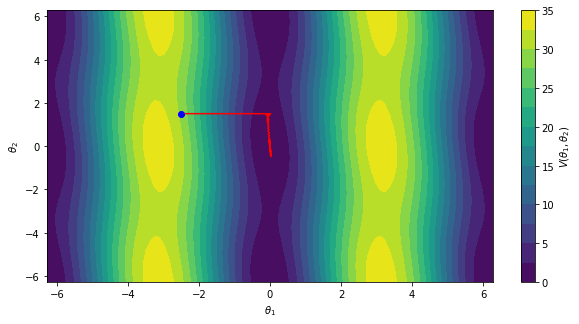

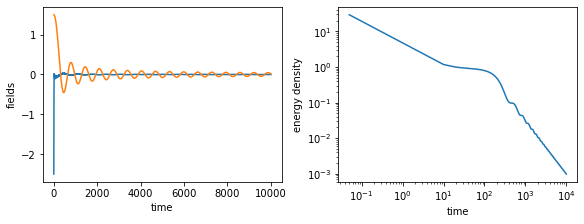

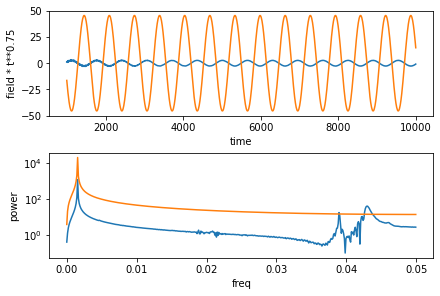

In [44]:
theta0s = np.array([-2.5, 1.5])
f = np.array([1, 100])
Lambda = np.array([1, 2])
Q = np.array([[1,1], [1, 0]])
sim(theta0s, f, Lambda, Q, time=1e4, nsamples=1000)